In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, MaxNLocator)

from pyphasechip import pyphasechip_logic as pypc
from typing import Tuple

## Variables

In [2]:
# reagent 1 name
name_sol1 = "BSA"
# reagent 1 starting contentration
initial_conc_sol1 = 266
# unit
unit_sol1 = "µM"


# reagent 2 name
name_sol2 = "PEG"
# reagent 2 starting concentration
initial_conc_sol2 = 10
# unit
unit_sol2 = "%"


# mixing ratio of the concentrations 0
# [1:X]
initial_ratio = 7


# Number of different concentrations used
number_of_diff_conc = 3

# Number of wells per row(!) per concentrations
# usually equals 10
n_wells = 1

# How many hours did the experiment last?
hours_of_experiment = 17


# How many pictures where taken per hour per well?
images_per_hour = 1


# percental difference of img mean to all previous imgages. 
# value is similar to a sensivity-value
percental_threshold = 10 


# measured diameter of chamber to calculate radii for circle detection -> min and max [px]
# around +-30 of the real value, best measured with something like imageJ/Fiji
diameter = 238 
minRadiusChamber = int((diameter/2)*0.7)
maxRadiusChamber = int((diameter/2)*1.3)


# height of chamber [µm]
chamber_height = 60

# folder where images are stored
# best is to use only paths without any whitespace
#image_folder = "C:Users/DigitalStation/Documents/Universität Stuttgart/Institut für industrielle Bioverfahrenstechnik/1_Masterthesis/Experiments/20210804 First OFM Exp/Images"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages"

image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\testimages2+"
#image_folder = r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages3"

# datatype of the images
extension = ".jpg"

In [ ]:
import PIL.Image
from datetime import datetime
import PIL.ExifTags
import dateutil.parser

img = PIL.Image.open(r"C:\Users\DigitalStation\Documents\Python_Scripts\DropletDetection\TestImages3\c0_w0_s0t1c0x0-1007y0-1128.jpg")
exif_data = img._getexif()
exif = {
    PIL.ExifTags.TAGS[k]: v
    for k, v in img._getexif().items()
    if k in PIL.ExifTags.TAGS
}

date = exif['DateTimeOriginal']
print(date)

In [ ]:
import PIL.Image
from datetime import datetime
import PIL.ExifTags
import dateutil.parser


#print(type(yourdate))

import os
import re
import numpy as np

In [ ]:
%%timeit
def get_sorted_file_list(image_folder: str) -> list:
    files, times, concs, wells = [], [], [], []
    
    for file in os.listdir(image_folder):
        # 1. More robust, faster, but more specific
        c, w, _, t = re.search("c(\d+)_w(\d+)_s(\d+)t(\d+)", file).groups()

        # 2. Other way
        #c, w, _, t, *params = re.findall('[0-9]+', file)
        
        # Generate lists
        times.append(int(t))
        concs.append(int(c))
        wells.append(int(w))
        files.append(file)
        
    return [x for _, _, _, x in sorted(zip(concs, times, wells, files))]
    
get_sorted_file_list(image_folder)

## Programm

In [3]:
# Create all the necessary dicts and lists
image_list, image_names, data_well, well, concentration, time_resolution = pypc.create()

# Load images & convert to grayscale
pypc.images_to_list(image_list, image_names, image_folder, extension)
pypc.images_to_dict(hours_of_experiment, images_per_hour, number_of_diff_conc, n_wells, image_list, image_names,
                    time_resolution, concentration, well, data_well)

# Detect chamber, create & apply mask
pypc.chamber_detection_and_mask_creation(number_of_diff_conc, n_wells, time_resolution, minRadiusChamber, maxRadiusChamber)

# Detect LLPS
pypc.detect_LLPS(hours_of_experiment, images_per_hour, number_of_diff_conc, n_wells,
                 time_resolution, percental_threshold)

# Calculate c_crit
starting_concentrations = pypc.ccrit_calculation(initial_conc_sol1, initial_conc_sol2, initial_ratio,
                       hours_of_experiment, images_per_hour, number_of_diff_conc, n_wells, time_resolution)

# saves the image names where LLPS was detected and the calculated concentrations to a csv file
# .csv gets safed in the image folder
#pypc.save_results_to_csv(time_resolution, image_folder, number_of_diff_conc, n_wells, hours_of_experiment,
#                       images_per_hour, name_sol1, name_sol2, unit_sol1, unit_sol2)


Creating and sorting image list


100%|███████████████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 152.72it/s]


writing images into big dictionary


100%|█████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 108.49it/s]


detect chambers and create masks


  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

no droplet @ t0 for c0_w0


 33%|████████████████████████████                                                        | 1/3 [00:08<00:17,  8.87s/it]

no droplet @ t0 for c0_w1
no droplet @ t0 for c1_w0


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:26<00:00,  8.82s/it]

no droplet @ t0 for c2_w1
LLPS detection



  7%|█████▉                                                                             | 1/14 [00:00<00:02,  5.32it/s]

no droplet could be found in well t4_c1_w0


 14%|███████████▊                                                                       | 2/14 [00:03<00:23,  1.94s/it]

no droplet could be found in well t4_c1_w1


100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:05<00:00,  2.60it/s]

no droplet could be found in well t9_c1_w1
calculation of the critical concentration



100%|██████████████████████████████████████████████████████████████████████████████████████████| 18/18 [00:00<?, ?it/s]


## quality control

Well found:  True
Droplet found:  True
LLPS found:  True
file name:  t6_well0_0
 
initial concentrations:
BSA  PEG
[[228.           1.42857143]
 [180.5          3.21428571]
 [133.           5.        ]
 [ 85.5          6.78571429]
 [ 38.           8.57142857]]
 
LLPS concentrations:
BSA - conc.: 341.303 µM
PEG - conc.: 2.138 %
 
Areas: 48927   32685


KeyError: 'subtracted'

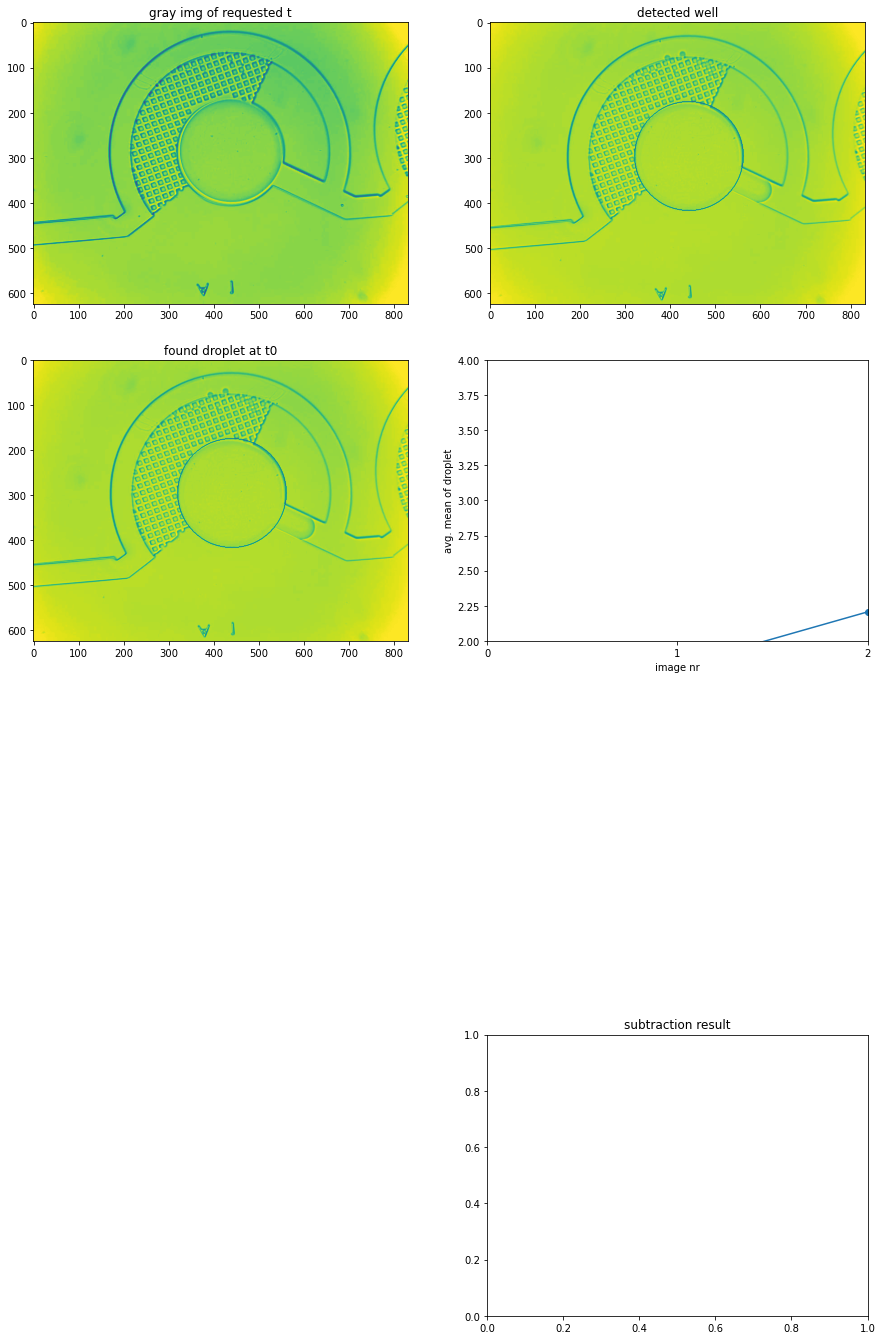

In [4]:
#5,0,0

# time to check
time_idx = 3

# concentration to check
conc_nr = 0

# well to check
well_nr = 0


# uncomment this to get some insight into image processing
pypc.quality_control(time_resolution, time_idx, conc_nr, well_nr, name_sol1, name_sol2,
                     unit_sol1, unit_sol2, starting_concentrations, time_resolution[0][conc_nr][well_nr]['well geometry'])

In [ ]:
print("calculated starting area", time_resolution[0][conc_nr][well_nr]['areas'][0, 0])
print("calculated final area", time_resolution[0][conc_nr][well_nr]['areas'][0, 1])
print("radius of well", time_resolution[0][conc_nr][well_nr]['well geometry'][0, 0, 2])
print("radius of droplet", time_resolution[0][conc_nr][well_nr]['droplet geometry'][0, 0, 2])
print("equ. result", 3.14159 * time_resolution[0][conc_nr][well_nr]['droplet geometry'][0, 0, 2] ** 2)


In [ ]:
def outside_std_dev(derv: np.ndarray) -> np.ndarray:
    # Checks if value is outside the 1st std
    # if so, it sets the value to 1, all other values are zeros
    outside_std = np.zeros(len(derv))
   
    for idx, y in enumerate(derv):
        if (y > np.median(derv) + np.std(derv)) or (y < np.median(derv) - np.std(derv)):
            outside_std[idx] = 1
    
    return outside_std
            
    
def find_edges(outside_std: np.ndarray, search_length: int = 20) -> Tuple[int, int]:
    # set up array for the left side
    # made up of zeros with a the first element as a one, this is the desired pattern we look for
    searchval = np.zeros(search_length)
    searchval[0] = 1
    
    # array for the right side
    searchval_rev = searchval[::-1]

    N = len(searchval)
    # searches for all the ones in outside_std
    possibles = np.where(outside_std == searchval[0])[0]
    
    # outside_std = [0, 1, 0, 0, 1, 0, 0]
    # possibles = [1, 4]; index of possible solutions
    # check = outside_std[1:2]; full slice of possible solutions 

    solns = []
    for p in possibles:
        check = outside_std[p : p + N]
       
        # checking if full slice matches my desired pattern (which is defined by searchval)
        # gives you all the patterns that matches your searval
        if np.all(check == searchval):
            solns.append(p)
    
    # doing the same stuff for the right side
    possibles = np.where(outside_std == searchval_rev[0])[0]

    solns_rev = []
    for p in possibles:
        check = outside_std[p:p+N]
        if np.all(check == searchval_rev):
            solns_rev.append(p + search_length -1)
    
    left_edge, right_edge = solns, solns_rev
    print("poss. solutions left",solns)
    print("poss. solutions right", solns_rev)
    # selecting the first solution from the left side and last solution from the right side
    return left_edge[0], right_edge[-1], solns, solns_rev

In [ ]:
outside_std = outside_std_dev(derv)
left_edge, right_edge = find_edges(outside_std, search_length=20)

In [ ]:
## profile plot test
array = np.array([[0,0,0,0,0],
                 [0,2,3,9,0],
                 [0,1,10,8,0],
                 [0,7,4,6,0],
                 [0,0,0,0,0]])


t = 5
c = 0
w = 0


img = time_resolution[t][c][w]['gray'].copy()
x = time_resolution[0][c][w]['circles'][0,0,0]
y = time_resolution[0][c][w]['circles'][0,0,1]
r = time_resolution[0][c][w]['circles'][0,0,2]

f = 1.1
L = int(x-f*r)
R = int(x+f*r)

row = img[y][L:R]
l = np.arange(row.size)


img_wL = cv2.line(img.copy(), (L,y), (R,y), (255,0,0), 2)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=4, figsize=(15,15))
ax1.imshow(img_wL)

row_norm = row / np.median(row)
ax2.plot(l, row_norm)

ax3.plot(l, np.gradient(np.gradient(row / np.median(row)))+1)
derv = np.gradient(np.gradient(row / np.median(row)))+1
ax3.axhline(np.median(derv), color='tab:red', alpha=0.6)
ax3.axhline(np.median(derv) + np.std(derv), color='tab:orange', alpha=0.8)
ax3.axhline(np.median(derv) - np.std(derv), color='tab:orange', alpha=0.8)

outside_std = outside_std_dev(derv)
left_edge, right_edge, solns, solns_rev = find_edges(outside_std, search_length=20)
        

ax4.plot(l, outside_std)
ax4.vlines(solns,0,1,color='red')
ax4.vlines(solns_rev,0,1,color="tab:orange")
ax2.vlines(left_edge, ymin=np.min(row_norm), ymax=np.max(row_norm), color="tab:orange")
ax2.vlines(right_edge, ymin=np.min(row_norm), ymax=np.max(row_norm), color="tab:orange")

#ax2.set_ylim([0, 1.2])
print(x,y,r)


In [ ]:
# time to check
time_idx = 5


# concentration to check
conc_nr = 0

# well to check
well_nr = 0


# uncomment this to get some insight into image processing
quality_control(time_resolution, time_idx, conc_nr, well_nr, name_sol1, name_sol2,
                     unit_sol1, unit_sol2, starting_concentrations, time_resolution[0][conc_nr][well_nr]['circles'])

## Plot the data

In [ ]:
### figure setup ###


fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(18,8), sharex=False, sharey=False)

# set labels
ax1.set_xlabel(f"{name_sol2} [{unit_sol2}]")
ax1.set_ylabel(f"{name_sol1} [{unit_sol1}]")
ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.set_xlabel(ax1.get_xlabel())
ax2.xaxis.label.set_size(ax1.xaxis.label.get_size())
ax2.set_ylabel(ax1.get_ylabel())
ax2.yaxis.label.set_size(ax1.yaxis.label.get_size())

# set limits 
xlim = int(initial_conc_sol2 * 6)
ylim = int(initial_conc_sol1 * 6)
ax1.set_xlim(0, xlim)
ax1.set_ylim(0, ylim)
ax2.set_xlim(0, xlim)
ax2.set_ylim(0, ylim)

# set titles
ax1.set_title('individual wells', fontsize=25)
ax2.set_title('means', fontsize= 25)

# set ticks
ax1.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax1.tick_params(axis='y', which='minor', right=True)
ax1.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax1.tick_params(axis='x', which='minor', bottom=True, top=True)
ax1.minorticks_on()
ax1.xaxis.set_major_locator(MultipleLocator(20))
ax1.xaxis.set_minor_locator(AutoMinorLocator(10))
ax1.yaxis.set_major_locator(MultipleLocator(100))
ax1.yaxis.set_minor_locator(AutoMinorLocator(20))
ax1.xaxis.set_tick_params(which='both', width=2)
ax1.yaxis.set_tick_params(which='both', width=2)


ax2.tick_params(axis='y', which='major', right=True, color="black", labelcolor="black", direction='out', labelsize=15)
ax2.tick_params(axis='y', which='minor', right=True)
ax2.tick_params(axis='x', which='major', top=True, labeltop=False, direction='out', labelsize=15)
ax2.tick_params(axis='x', which='minor', bottom=True, top=True)
ax2.minorticks_on()
ax2.xaxis.set_major_locator(MultipleLocator(20))
ax2.xaxis.set_minor_locator(AutoMinorLocator(10))
ax2.yaxis.set_major_locator(MultipleLocator(100))
ax2.yaxis.set_minor_locator(AutoMinorLocator(20))
ax2.xaxis.set_tick_params(which='both', width=2)
ax2.yaxis.set_tick_params(which='both', width=2)


# plot starting concentrations and the data
well_nr = 0

for conc_nr in range (number_of_diff_conc):
    for n_rows_per_conc in range(2):
        for n_wells_per_row in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['well status'] is True and time_resolution[0][conc_nr][well_nr]['LLPS status'] is True:
            
                if conc_nr == 0:
                    color = "blue"
                if conc_nr == 1:
                    color = "orange"
                if conc_nr == 2:
                    color = "gray"
                if conc_nr == 3:
                    color = "yellow"
                if conc_nr == 4:
                    color = "green"

                ax1.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")
                ax1.scatter(time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1],time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0],
                            s=60, color=color, marker="o", edgecolors="black")
                
            well_nr += 1
    well_nr = 0
well_nr = 0


# calculate and plot mean
mean_sol1 = []
mean_sol1 = [0] * 5
mean_sol2 = []
mean_sol2 = [0] * 5
n_llps_wells = []
n_llps_wells = [0] * 5

for conc_nr in range (number_of_diff_conc):
    for n_rows_per_conc in range(2):
        for n_wells_per_row in range(n_wells):
            if time_resolution[0][conc_nr][well_nr]['well status'] is True and time_resolution[0][conc_nr][well_nr]['LLPS status'] is True:           
                # calculate mean
                mean_sol1[conc_nr] = mean_sol1[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,0]
                mean_sol2[conc_nr] = mean_sol2[conc_nr] + time_resolution[0][conc_nr][well_nr]['LLPS conc'][0,1]
                n_llps_wells[conc_nr] += 1
                
            well_nr += 1
    well_nr = 0
well_nr = 0


for conc_nr in range(number_of_diff_conc):
    if conc_nr == 0:
        color = "blue"
    if conc_nr == 1:
        color = "orange"
    if conc_nr == 2:
        color = "gray"
    if conc_nr == 3:
        color = "yellow"
    if conc_nr == 4:
        color = "green"
    if n_llps_wells[conc_nr] > 0:
        mean_sol1[conc_nr] = mean_sol1[conc_nr]/n_llps_wells[conc_nr]
        mean_sol2[conc_nr] = mean_sol2[conc_nr]/n_llps_wells[conc_nr]
        m = mean_sol1[conc_nr]/mean_sol2[conc_nr]
        
    ax2.plot([0, mean_sol2[conc_nr],xlim], [0, mean_sol1[conc_nr], m*xlim], color=color, linestyle='dashed', alpha=0.50)
    ax2.scatter(starting_concentrations[conc_nr,1], starting_concentrations[conc_nr,0], s=60, c=color, marker="s", edgecolors="black")

    ax2.scatter(mean_sol2[conc_nr],mean_sol1[conc_nr], s=60, color=color,
                           marker="o", edgecolors="black")
 